# Causal analysis
### This notebook contains some visuals of the dataset and the casual analysis
### By Xiao Lin
### Reference: 

Draw Causal Graph: https://lingam.readthedocs.io/en/latest/tutorial/draw_graph.html

Casual reasoning using lignum: https://github.com/KJMAN678/casual_reasoning_lignum/blob/master/LIGNAM.ipynb

Air polluant causal analysis: https://www.kaggle.com/code/sasakitetsuya/what-causes-pm2-5

# Initialization

In [34]:
'''
# Uncomment and install the packages below and restart the kernel when the notebook is loaded
!pip install lingam
!pip install pygam
!pip install factor_analyzer
!pip install category_encoders
!pip install lightgbm
'''

'\n# Uncomment and install the packages below and restart the kernel when the notebook is loaded\n!pip install lingam\n!pip install pygam\n!pip install factor_analyzer\n!pip install category_encoders\n!pip install lightgbm\n'

In [35]:
from utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image
import category_encoders as ce
import graphviz
import lingam
from lingam.utils import make_dot, make_prior_knowledge
from sklearn.linear_model import LinearRegression
import lightgbm as lgb

%matplotlib inline

In [36]:
# Prepare the entire dataset for graphing
aqi_df = df_prep_full(file_dir)
aqi_df

,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category
0,Russian Federation,Praskoveya,51,Moderate,1,Good,36,Good,0,Good,51,Moderate
1,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1,Good,41,Good
2,Italy,Priolo Gargallo,66,Moderate,1,Good,39,Good,2,Good,66,Moderate
3,Poland,Przasnysz,34,Good,1,Good,34,Good,0,Good,20,Good
4,France,Punaauia,22,Good,0,Good,22,Good,0,Good,6,Good
...,...,...,...,...,...,...,...,...,...,...,...,...
23458,India,Gursahaiganj,184,Unhealthy,3,Good,154,Unhealthy,2,Good,184,Unhealthy
23459,France,Sceaux,50,Good,1,Good,20,Good,5,Good,50,Good
23460,India,Mormugao,50,Good,1,Good,22,Good,1,Good,50,Good
23461,United States of America,Westerville,71,Moderate,1,Good,44,Good,2,Good,71,Moderate


# Prelimitary data visualization for causal analysis
### Boxplot by features
* Boxplots by features are plotted to demonstrate the distributions of each feature and what overall AQI category the data points fall into. The overall AQI value is also plotted for reference (See sub-figure 1).  
* It can be observed that the distribution of the PM2.5 AQI value has a very similar shape compared to that of the overall AQI value, indicating that there might be a strong correlation between them.  
* The other extreme cases are CO AQI and NO2 AQI, which have many outliers in the distribution, while most of the data points are in the lower value range. The lack of gradience between categories shows that these two pollutant AQIs might be weak in predicting the overall AQI value. 

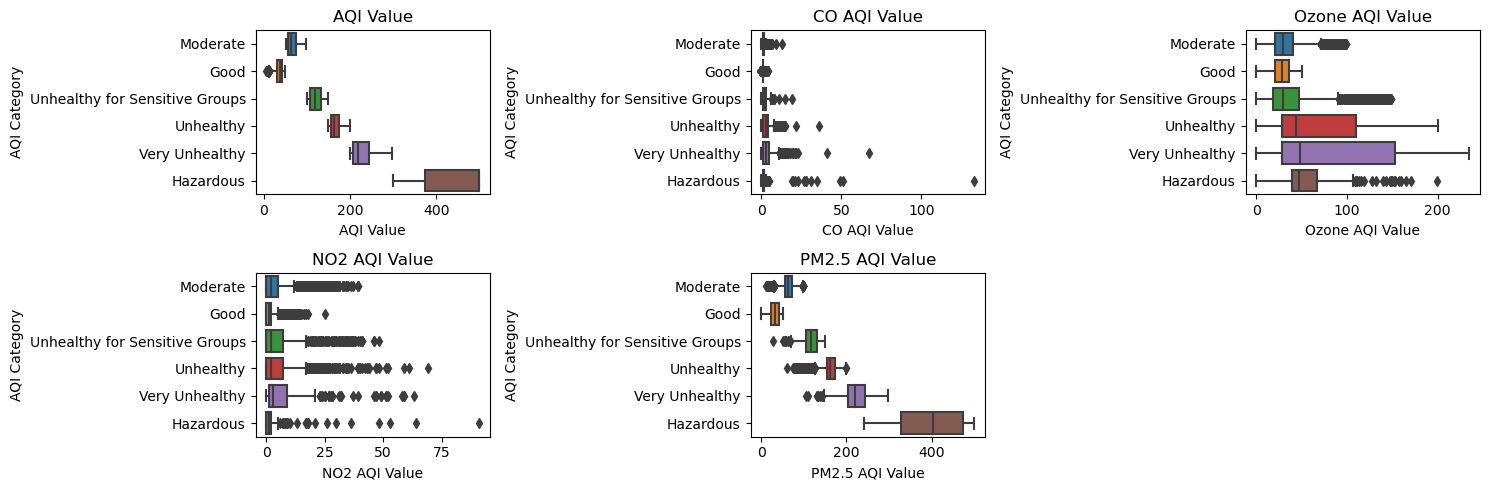

In [37]:
val_col = ['AQI Value', 'CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value', 'PM2.5 AQI Value']
fig = plt.figure(figsize=(15,5))

for i in range(len(val_col)):
    plt.subplot(2, 3, i+1)
    plt.title(val_col[i])
    sns.boxplot(data=aqi_df, x=aqi_df[val_col[i]], y=aqi_df['AQI Category'])

plt.tight_layout()
plt.show()

### Correlation matrix (from Data visualizations.ipynb)
* The correlation matrix heatmap of the features is plotted. The linear correlation between the PM2.5 AQI value and the overall AQI value of 0.98 is extremely high.

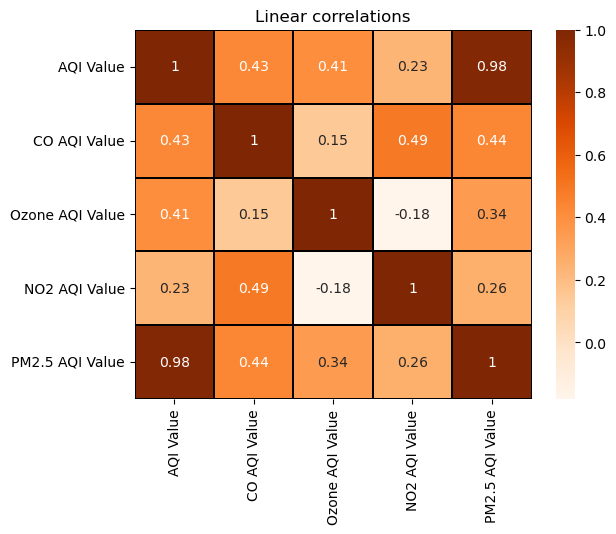

In [38]:
# plot a correlation matrix heatmap of the numberic data
def make_heatmap(data):
    cols = data.select_dtypes(include=('number'))
    corr_matrix = cols.corr()
    sns.heatmap(data=corr_matrix,
                cmap='Oranges', 
                linecolor='0000',
                linewidths=.1,
                annot=True)
    plt.title('Linear correlations')
    plt.show()

make_heatmap(aqi_df)

### Pairplot (Scatter plots)
* The scatter plots in a pairplot fashion illustrate the distribution for each block shown in the correlation matrix heatmap in greater detail. 

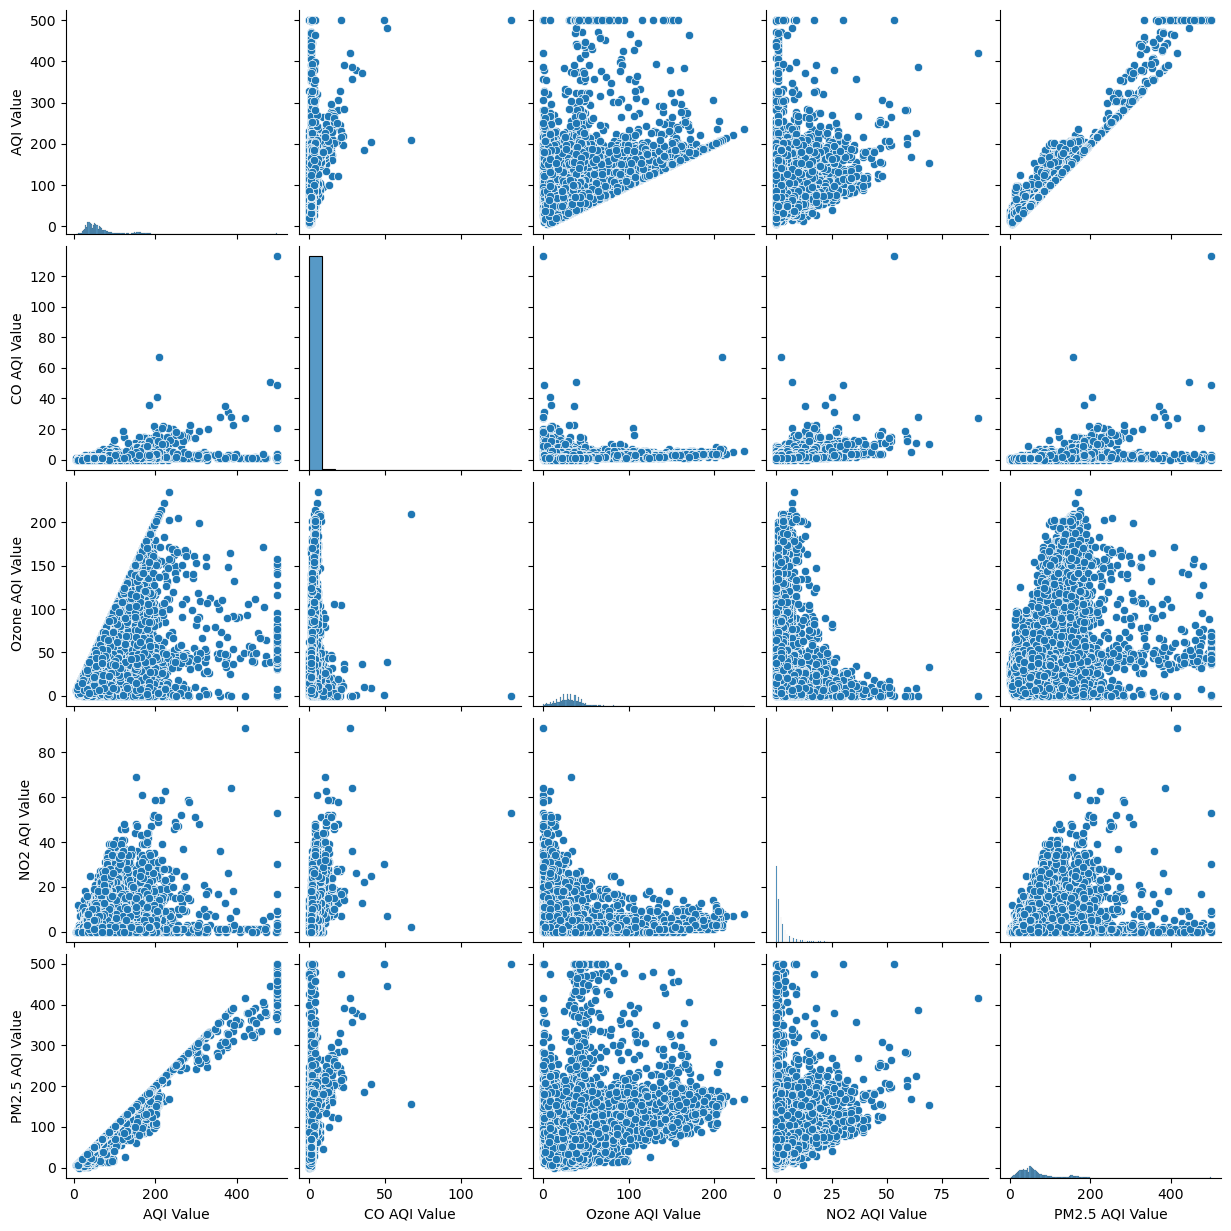

In [39]:
sns.pairplot(aqi_df)

### Lmplot (regression plot overlay) (PM2.5 vs. overall, R^2=0.98)
* The lmplot below is a color-coded and zoomed-in version of the bottom left sub-graph from the pairplot above. The plot shows PM2.5 value vs. overall AQI value, with each AQI category colored. It follows the expected linear trend, and the points are more scattered in higher AQI values (hazardous category), possibly due to the limited amount of data in this range.

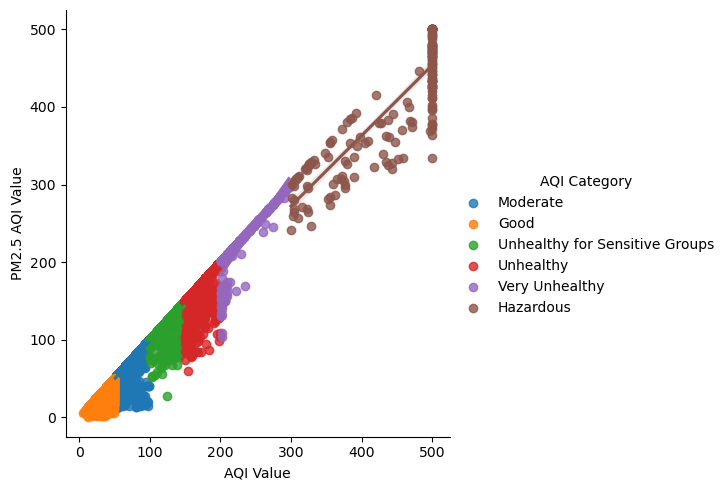

In [40]:
sns.lmplot(data=aqi_df, x='AQI Value', y='PM2.5 AQI Value', hue='AQI Category')

### Lmplot (regression plot overlay) (NO2 vs. CO, R^2=0.15)
* This lmplot shows NO2 AQI value vs. CO AQI value, with a low R square value of 0.15. No clear trend can be observed between the two features.

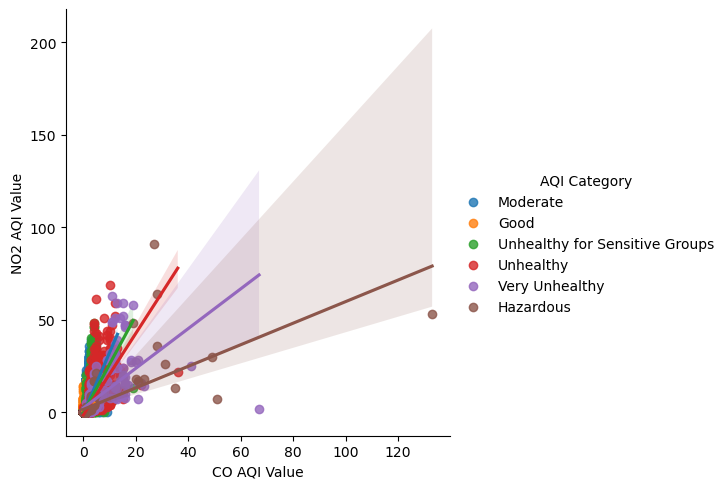

In [41]:
sns.lmplot(data=aqi_df, x='CO AQI Value', y='NO2 AQI Value', hue='AQI Category')

# Data preprocessing for causal inference model

In [42]:
# Remove unnecessary columns
aqi_test_df = aqi_df.drop(['Country', 'City', 'AQI Category', 'CO AQI Category', 'Ozone AQI Category', 'NO2 AQI Category', 'PM2.5 AQI Category'], axis=1)
aqi_df = aqi_test_df.drop(['AQI Value'], axis=1)

In [43]:
# Create a list and dict for better readability
aqi_list = aqi_df.columns.to_list()
aqi_dict = {}

for i, column in zip(range(len(aqi_list)), aqi_list):
    aqi_dict[column] = i

print(len(aqi_list))
print(aqi_dict)

4
{'CO AQI Value': 0, 'Ozone AQI Value': 1, 'NO2 AQI Value': 2, 'PM2.5 AQI Value': 3}


# Causal inference model analysis

In [44]:
# Setting prior knowledge
prior_knowledge = make_prior_knowledge(4, 
                                       sink_variables = [aqi_dict['PM2.5 AQI Value']],
                                       paths = [
                                           [aqi_dict['CO AQI Value'], aqi_dict['NO2 AQI Value'], aqi_dict['Ozone AQI Value']]
                                       ])

# Build the causal inference model
model = lingam.DirectLiNGAM(
                    random_state=42,
                    measure='pwling',
                    prior_knowledge = prior_knowledge
                    )

# Train the model
model.fit(aqi_df)

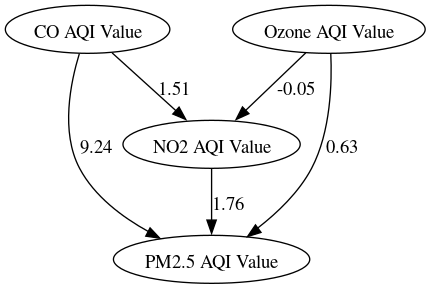

In [52]:
# Generate the causal graph
dot = make_dot(model.adjacency_matrix_, labels=aqi_list)
dot.format = 'png'
dot.render('causal graph dag')
Image('causal graph dag.png')

In [46]:
# Generate correlation coefficient for features in the trained model
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(aqi_df, aqi_test_df['AQI Value'])

LinearRegression()

features:  [0, 1, 2, 3]


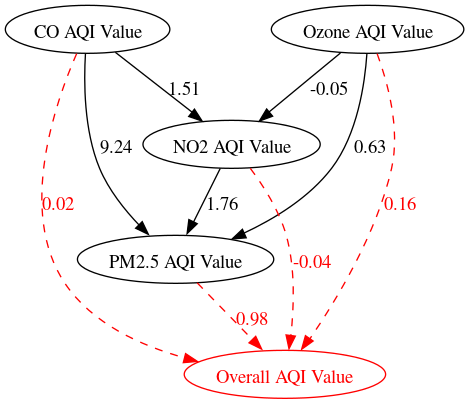

In [47]:
# Use the correlation coefficient above to generate the causal prediction graph
features = [i for i in range(aqi_df.shape[1])]
print("features: ", features)

dot = make_dot(
    model.adjacency_matrix_,
    labels=aqi_list,
    prediction_feature_indices=features, 
    prediction_target_label='Overall AQI Value',
    prediction_coefs=lin_reg.coef_
    )

dot.format = 'png'
dot.render('causal prediction dag')

Image("causal prediction dag.png")

In [48]:
# Generate feature importances using LightGBM
lgbm_reg = lgb.LGBMRegressor(random_state=0)
lgbm_reg.fit(aqi_df, aqi_test_df['AQI Value'])
lgbm_reg.feature_importances_

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 526
[LightGBM] [Info] Number of data points in the train set: 23463, number of used features: 4
[LightGBM] [Info] Start training from score 72.010868


array([ 147, 1213,  105, 1535], dtype=int32)

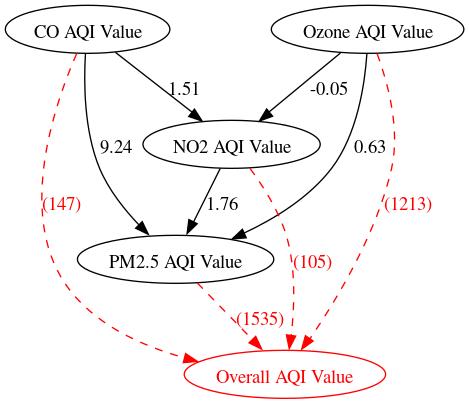

In [49]:
# Use the feature importances above to generate the feature importance graph
dot = make_dot(
    model.adjacency_matrix_,
    labels=aqi_list,
    prediction_feature_indices=features, 
    prediction_target_label='Overall AQI Value',
    prediction_feature_importance=lgbm_reg.feature_importances_
    )

dot.format = 'png'
dot.render('feature importances dag')

Image("dag.png")

In [50]:
# Estimating the feature that have the greatest causal influence on predictions
casual_effect = lingam.CausalEffect(model)
effects = casual_effect.estimate_effects_on_prediction(aqi_df, 4, lgbm_reg)

df_effects = pd.DataFrame()
df_effects['feature'] = aqi_df.columns
df_effects['effect_plus'] = effects[:, 0]
df_effects['effect_minus'] = effects[:, 1]*-1
display(df_effects)

max_index = np.unravel_index(np.argmax(effects), effects.shape)
print(f'The feature that has the most impact to the overall AQI value is {aqi_df.columns[max_index[0]]}.')

,feature,effect_plus,effect_minus
0,CO AQI Value,21.124042,-21.934679
1,Ozone AQI Value,18.168882,-18.954474
2,NO2 AQI Value,9.174006,-9.974812
3,PM2.5 AQI Value,53.823895,-34.001596


The feature that has the most impact to the overall AQI value is PM2.5 AQI Value.
